In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from pathlib import Path

# %pip install openpyxl

As I will need to keep all the decimal digits for APR calculations later on, I will display just 5 decimals for visibility, but will work with all decimals available for APR.

In [89]:
# Displaying options:
pd.set_option('display.float_format', '{:.5f}'.format)

# Average exange rate from EUR to CZK for 2023
czech_crowns_per_euro_2023 = 24.0168

In [90]:

# Reading the excel file

source_path = Path('/Users/arortega/Desktop/git/world_bank_etl/test_pwc/data_source/pwc_bank_data.csv')

df = (
    pd.read_csv(
        source_path,
        encoding='utf-16'
    )
)

# Dropping the first empty column which came from the Excel export

df = (
    df
    .drop(
        columns=df.columns[0]
    )
)

df.head()



,CustomerID,Name,Address,Phone,Phone_2,Email,DateJoined,AccountID,BranchID,AccountType,...,TransactionID,Date,Type,Amount,Fee,BranchName,ManagerID,EmployeeID,Position,DateHired
0,1.00000,Allison Hill,"819 Johnson Course,East William, AK 74064",886.737.9402,223-951-1615x594,dudleynicholas@example.net,2013-11-30,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.00000,Lisa Hensley,"34131 Ramirez Roads,Franciscostad, IL 88342",719-228-3276x483,505.964.1395,pwilkerson@example.com,2008-10-19,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.00000,David Hoffman,"653 William Course Apt. 122,Carlsonfurt, MS 78605",484.980.1845x146,5484281489,kathryn88@example.org,2014-12-20,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.00000,Brian Cox DVM,"39117 Tiffany Place,East Donna, OH 22144",989-363-8346x578,531.250.9839,zimmermanbrian@example.org,2005-01-03,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.00000,Andrea Young,"299 Sanchez Mountains,Leeville, TN 56999",(566)970-1065x133,(362)247-3178,novaksara@example.org,2009-08-06,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We can see several things to fix. For example:
- The date fields shall be cast to datetype
- There are missing values everyowhere which need further investigation
- ID fields are floats instead of integers
- Balance columns is object type, which needs to be fixed since it should be flaot.

In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3398 entries, 0 to 3397
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CustomerID     250 non-null    float64
 1   Name           164 non-null    object 
 2   Address        108 non-null    object 
 3   Phone          147 non-null    object 
 4   Phone_2        80 non-null     object 
 5   Email          164 non-null    object 
 6   DateJoined     100 non-null    object 
 7   AccountID      3226 non-null   float64
 8   BranchID       222 non-null    float64
 9   AccountType    150 non-null    object 
 10  DateOpened     150 non-null    object 
 11  Balance        150 non-null    object 
 12  APR            150 non-null    object 
 13  TransactionID  3076 non-null   float64
 14  Date           3076 non-null   object 
 15  Type           3076 non-null   object 
 16  Amount         3076 non-null   object 
 17  Fee            3076 non-null   float64
 18  BranchNa

## 0. Initial EDA (final EDA performed after modeling)

As I discovered during EDA, columns 'Phone' and 'Phone_2' have missing values. In order for my functions to work properly managing nulls, I will fill the na's with the string 'No Phone' for the missing phones. This should not disturb the data, since phones are not primary or secondary keys anywhere.

In [92]:
df['Phone'] = df['Phone'].fillna('missing_phone_1')
df['Phone_2'] = df['Phone_2'].fillna('missing_phone_2')

I will now cast all columns accordingly.

In [93]:
df['DateJoined'] = pd.to_datetime(
    df['DateJoined']
    , errors='coerce'
)

df['DateOpened'] = pd.to_datetime(
    df['DateOpened']
    , errors='coerce'
)

df['Date'] = pd.to_datetime(
    df['Date']
    , errors='coerce'
)

df['DateHired'] = pd.to_datetime(
    df['DateHired']
    , errors='coerce'
)


For some reason during the export, the ID columns were cast as flaots and when cast into integers, they remove the last digit. We will cast them as integers and add a 0 (or multiply by 10) to match the original csv.

In [94]:
df['CustomerID'] = df['CustomerID'].astype('Int64') * 10
df['AccountID'] = df['AccountID'].astype('Int64') * 10
df['BranchID'] = df['BranchID'].astype('Int64') * 10
df['TransactionID'] = df['TransactionID'].astype('Int64') * 10
df['ManagerID'] = df['ManagerID'].astype('Int64') * 10
df['EmployeeID'] = df['EmployeeID'].astype('Int64') * 10



## 1. Data modeling

The file contains 5 different tables (entities) combined in the same one. First, we need to separate and save the 5 different entities in 3 different tables (dataframes) and stablish their relationships, meaning Primary and Foreign keys.

The main entities are:
- Customers
- Branches
- Employees
- Accounts
- Transactions

I figured the data model by checking which columns are filled for the different values. I attach a descriptive image of the RDB model with the respective relationships.

In [95]:
# Let's instantiate the data model's columns dictionary

data_model_columns = {
    'customers': [
        'CustomerID', 'Name', 'Address', 'Phone', 
        'Phone_2', 'Email', 'DateJoined'
    ],
    'branches': [
        'BranchID', 'BranchName', 'Address', 'ManagerID',
    ],
    'employees': [
        'EmployeeID', 'BranchID', 'Position', 'DateHired', 
        'Name', 'Phone', 'Email'
    ],
    'accounts': [
        'AccountID', 'BranchID', 'AccountType',
        'Balance', 'DateOpened', 'APR', 'CustomerID'
    ],
    'transactions': [
        'TransactionID', 'AccountID', 'Amount', 'Date', 'Type', 'Fee'
    ]
}



I will write a helper function that will split the main df in different tables, based on the data model and the missing/filled values:

In [96]:
def split_tables(df, data_model_columns):
    tables = {}
    for table_name, columns in data_model_columns.items():
        # Just the columns existing in the df
        valid_cols = [col for col in columns if col in df.columns]

        if not valid_cols:
            continue  # if no columns exist, skip

        # Create a boolean mask where all columns must have data (notnull)
        mask = df[valid_cols].notnull().all(axis=1)

        # Filter rows + keep only those columns
        tables[table_name] = df.loc[mask, valid_cols]

    return tables

tables = split_tables(df, data_model_columns)

customers = tables['customers']
branches = tables['branches']
employees = tables['employees']
accounts = tables['accounts']
transactions = tables['transactions']



Lastly, we will rename the ambiguious columns to avoid confussions. I will write a small helper function for that as well:

In [97]:
# The tables in the entity list are the only ones with confusing column names
entity_list = ['customers', 'branches', 'employees']

def rename_columns(df, entity):
    df = (
        df
        .rename(
            columns={
                'Name': f'{entity}_name',
                'Phone': f'{entity}_phone',
                'Email': f'{entity}_email',
                'Address': f'{entity}_address'
            }
        )
    )

    return df

customers = rename_columns(customers, 'customers')
branches = rename_columns(branches, 'branches')
employees = rename_columns(employees, 'employees')



## 2. Final EDA

I will split and clean the 'Balance' column in accounts_df, into 2 different columns:
- Amount
- Currency

This way would be much easier and consistent to overview the products and balance

In [98]:
accounts['Currency'] = (
    accounts['Balance']
    .str.extract(r'([A-Z]+)$')
)

accounts['balance_flat'] = (
    accounts['Balance']
    .str.extract(r'([0-9.eE+-]+)')
)

accounts['balance_flat'] = (
    accounts['balance_flat']
    .astype(float)
)

accounts['balance_flat'] = (
    accounts['balance_flat']
    .round(2)
)



'Amount' from Transactions came with commas (,) instead of decimal points, so I will replace them and then cast 'Amount' as flaot for final EDA:

In [99]:
transactions['Amount'] = transactions['Amount'].str.replace('[$,]', '.', regex=True)
transactions['Amount'] = transactions['Amount'].astype(float)

Renaming column 'Type' from transactions to 'transaction_type' and same for 'AccountType' to 'account_type'

In [100]:
transactions.rename(columns={'Type': 'transaction_type'}, inplace=True)
accounts.rename(columns={'AccountType': 'account_type'}, inplace=True)

And finally, 'APR' from accounts comes as strings, with decimal commas instead of points and scientific notation. I will cast them as floats.

In [101]:
print(accounts['APR'].to_list())

['5,0000000000000003E-2', '5,9999999999999998E-2', '7,0000000000000007E-2', '0', '4,0000000000000001E-2', '0', '0,02', '0,02', '8,0000000000000002E-2', '0', '0', '0,11', '0,10000000000000001', '8,0000000000000002E-2', '0', '0,02', '7,0000000000000007E-2', '8,9999999999999997E-2', '0,11', '0', '0,02', '0', '0,02', '4,0000000000000001E-2', '0,12', '7,0000000000000007E-2', '8,9999999999999997E-2', '4,0000000000000001E-2', '5,9999999999999998E-2', '8,9999999999999997E-2', '0,11', '0,02', '5,0000000000000003E-2', '5,9999999999999998E-2', '5,0000000000000003E-2', '0', '0,12', '0', '5,0000000000000003E-2', '0', '5,0000000000000003E-2', '0', '8,9999999999999997E-2', '0', '4,0000000000000001E-2', '5,0000000000000003E-2', '5,0000000000000003E-2', '5,9999999999999998E-2', '0,12', '8,9999999999999997E-2', '5,9999999999999998E-2', '5,9999999999999998E-2', '7,0000000000000007E-2', '0', '0,02', '0,02', '8,9999999999999997E-2', '5,0000000000000003E-2', '0', '0,11', '5,9999999999999998E-2', '8,99999999

In [102]:
accounts['APR'] = (
    accounts['APR']
    .astype(str)
    .str.replace(',', '.', regex=False)
    .astype(float)
    .round(3)
)


___

## 3. Main Questions

### 3.1. Overview of available banking products and their current volume

In [103]:
accounts.groupby('account_type').size()

account_type
Current    45
Loan       50
Saving     55
dtype: int64

Calculate APR and Fees by account type

In [104]:
transactions_accounts = (
    transactions
    .merge(
        accounts
        , on='AccountID'
        , how='right'
    )
)

volumne_balance_per_product = (
    transactions_accounts
    .groupby(
        ['account_type', 'Currency']
        , as_index=False
    )
    .agg(
        transaction_count = ('TransactionID', 'count')
        , balance_sum = ('balance_flat', 'sum')
        , balance_mean = ('balance_flat', 'mean')
        , balance_median = ('balance_flat', 'median')
        , balance_std = ('balance_flat', 'std')
        , balance_min = ('balance_flat', 'min')
        , balance_max = ('balance_flat', 'max')
    )
)

volumne_balance_per_product

,account_type,Currency,transaction_count,balance_sum,balance_mean,balance_median,balance_std,balance_min,balance_max
0,Current,CZK,1360,71933908.70000,52892.57993,54219.50000,28684.07055,782.31000,94606.20000
1,Loan,EUR,0,33907383.70000,678147.67400,740550.00000,358874.84549,29580.50000,1220260.00000
2,Saving,CZK,1716,3322686465.40000,1936297.47401,1942560.00000,1121071.97304,12981.20000,3887550.00000


In [105]:
display(
    transactions_accounts
    .groupby(
        'transaction_type'
        , as_index=False
    )
    .agg(
        {
            'Amount' : 'mean'
        }
    )
)

,transaction_type,Amount
0,Bonus,500.00000
1,Deposit,3877.53047
2,Transfer,1467.38338
3,Withdrawal,1504.68054


In [106]:
# Transactions table doesn't have currency information, just the amount. I need to see if each account can only
# have one type of currency or multiple types.

display(
    transactions_accounts
    .groupby(
        ['AccountID', 'Currency']
        , as_index=False
    )
    .agg(
        currency_count = ('Currency', 'nunique')
    )
)

,AccountID,Currency,currency_count
0,10,CZK,1
1,20,CZK,1
2,30,EUR,1
3,40,CZK,1
4,50,CZK,1
...,...,...,...
145,1460,CZK,1
146,1470,EUR,1
147,1480,CZK,1
148,1490,EUR,1


In [107]:
# There's a total of 150 unique accounts, and each accounts has only one Currency type, meaning transactions on each account
# respective currency correspond to the account's currency.

accounts['AccountID'].nunique()


150

In [108]:
# Furthermore, the only accounts in EUR are the savings accounts, for some reason. Rest of account types are in CZK.

accounts_test = accounts.copy()
accounts_test = accounts_test[accounts_test['account_type'] == 'Loan']

display(
    accounts_test
    .groupby(
        ['account_type', 'Currency']
        , as_index=False
    )
    .agg(
        unique_values = ('AccountID', 'nunique')
    )
)


,account_type,Currency,unique_values
0,Loan,EUR,50


In [109]:
# There are no transactions for loan accounts, which means that we can study all transactions in CZK currency.

display(
    transactions_accounts
    .groupby(
        'account_type'
        , as_index=False
    )
    .agg(
        unique_values = ('TransactionID', 'nunique')
    )
)

,account_type,unique_values
0,Current,1360
1,Loan,0
2,Saving,1716


In [110]:
# Bar plot of number of transactions per Account Type (product)

In [111]:
accounts_total_balance = (
    transactions_accounts
    .groupby(
        'account_type'
        , as_index=False
    )
    .agg(
        total_balance=('balance_flat', 'sum')
    )
)

display(
    accounts_total_balance
)



,account_type,total_balance
0,Current,71933908.70000
1,Loan,33907383.70000
2,Saving,3322686465.40000


In [112]:
accounts_total_balance.loc[accounts_total_balance['account_type']=='Loan', 'total_balance'] *= czech_crowns_per_euro_2023

accounts_total_balance

,account_type,total_balance
0,Current,71933908.70000
1,Loan,814346852.84616
2,Saving,3322686465.40000


In [113]:
current_date = transactions_accounts['Date'].max().strftime('%Y-%m-%d')

/var/folders/6k/zfk3kxb1447czyrbwnhwzgsw0000gn/T/ipykernel_5501/1502975161.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




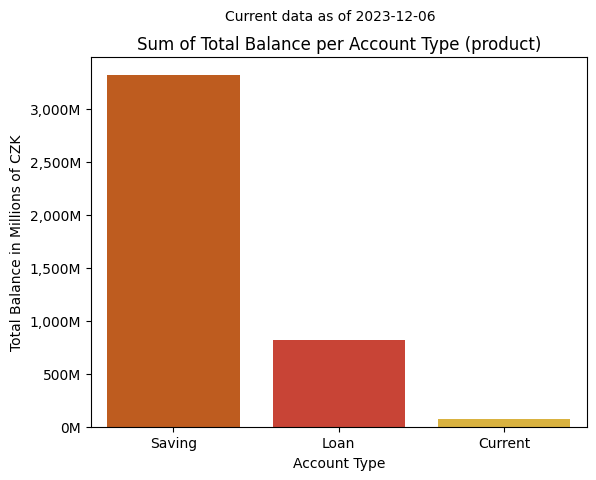

In [114]:
# Bar plot of total balance per Account Type (product)

palette_account_types = {
    'Loan': '#E0301E',
    'Saving': '#D85604',
    'Current': '#F3BE26'
}

fig, ax = plt.subplots()

sns.barplot(
    data=(
        accounts_total_balance
        .sort_values(by='total_balance', ascending=False)
    )
    , x='account_type'
    , y='total_balance'
    , palette=palette_account_types
    , ax=ax
)

ax.set_title('Sum of Total Balance per Account Type (product)')
fig.suptitle(
    f'Current data as of {current_date}'
    ,fontsize=10,
)

plt.xlabel('Account Type')
plt.ylabel('Total Balance in Millions of CZK')

formatter = mtick.FuncFormatter(lambda x, _: f'{x/1_000_000:,.0f}M')
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()

### 3.2. Count and volume of transactions per product (Some transactions might be inconsistent)

In [115]:
count_vol_transactions = (
    transactions_accounts
    .groupby(
        ['account_type', 'transaction_type']
        , as_index=False
    )
    .agg(
        count = ('TransactionID', 'count'),
        transaction_mean = ('Amount', 'mean'),
        transaction_max = ('Amount', 'max'),
        transaction_min = ('Amount', 'min'),
        transaction_std = ('Amount', 'std')
    )
)

display(
    count_vol_transactions
)

# We found an outlier transaction, where a huge ammount was deposted on a savings account
# There are no withdrawals nor transfers from the savings accounts

,account_type,transaction_type,count,transaction_mean,transaction_max,transaction_min,transaction_std
0,Current,Deposit,463,1450.35458,2991.83000,12.52000,872.56783
1,Current,Transfer,455,1467.38338,2996.97000,13.01000,857.69133
2,Current,Withdrawal,442,1504.68054,2992.39000,15.85000,855.23263
3,Saving,Bonus,51,500.00000,500.00000,500.00000,0.00000
4,Saving,Deposit,1665,4552.47488,3520663.57000,10.51000,90300.00460


In [116]:
# We will use the inter quartile range to identify outliers
Q1 = transactions_accounts['Amount'].quantile(0.25)
Q3 = transactions_accounts['Amount'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = transactions_accounts[
    (transactions_accounts['Amount'] < lower_bound) |
    (transactions_accounts['Amount'] > upper_bound)
]

display(outliers)



,TransactionID,AccountID,Amount,Date,transaction_type,Fee,BranchID,account_type,Balance,DateOpened,APR,CustomerID,Currency,balance_flat
25,29950,10,10250.66000,2023-05-21,Deposit,50.00000,50,Saving,12981.2 CZK,2023-05-21,0.05000,930,CZK,12981.20000
1006,30260,510,3520663.57000,2023-07-27,Deposit,50.00000,20,Saving,3.52346e+006 CZK,2023-07-27,0.06000,480,CZK,3523460.00000
1035,30210,520,631037.20000,2023-07-15,Deposit,50.00000,70,Saving,630987 CZK,2023-07-15,0.06000,910,CZK,630987.00000
2845,29630,1360,896938.80000,2023-02-17,Deposit,50.00000,80,Saving,896889 CZK,2023-02-17,0.01000,840,CZK,896889.00000


We can observe there are 4 main outliers in the data, which correspond to big deposits made in savings accounts, and skew the deposit ammount mean. To better understand transactions nature, we will eliminate them from the df, since they don't really add any value to our study.

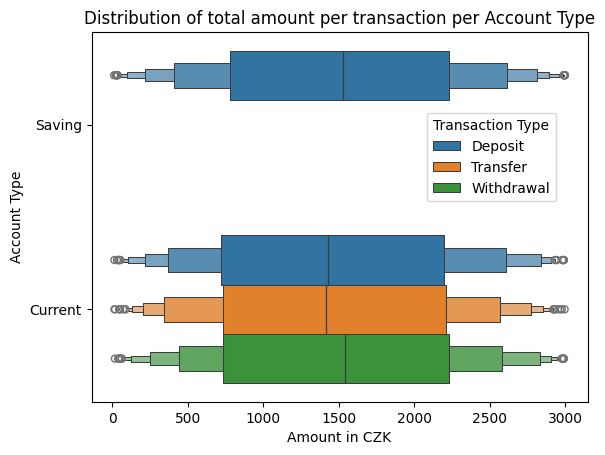

In [117]:
outliers_ID_list = outliers['TransactionID'].tolist()

# We will remove the outliers from the dataset. Moreover, we are also removing the 'Bonus' transactions, since they don't
# add to much value to the graph

transactions_accounts_clean = transactions_accounts[
    (~transactions_accounts['TransactionID'].isin(outliers_ID_list))
    & (transactions_accounts['transaction_type'] != 'Bonus')
]

ax = sns.boxenplot(
    data=(
        transactions_accounts_clean[
            transactions_accounts_clean['account_type'] != 'Loan'
        ]
    )
    , x='Amount'
    , y='account_type'
    , hue='transaction_type'
)

ax.legend(title='Transaction Type', loc='upper right', bbox_to_anchor=(0.95, 0.8))

plt.title('Distribution of total amount per transaction per Account Type')
plt.xlabel('Amount in CZK')
plt.ylabel('Account Type')

plt.show()


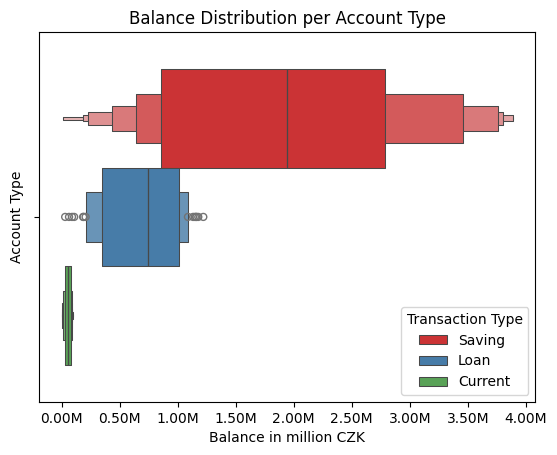

In [118]:
ax = sns.boxenplot(
    data=transactions_accounts
    , x='balance_flat'
    # , y='account_type'
    , hue='account_type'
    , palette='Set1'
)

formatter = mtick.FuncFormatter(lambda x, _: f'{x/1_000_000:,.2f}M')
plt.gca().xaxis.set_major_formatter(formatter)

ax.legend(title='Transaction Type', loc='lower right')

plt.title('Balance Distribution per Account Type')
plt.xlabel('Balance in million CZK')
plt.ylabel('Account Type')

plt.show()



In [119]:
display(
    transactions_accounts[
        (transactions_accounts['account_type'] == 'Loan')
        & (transactions_accounts['TransactionID'].notnull())
    ]
)

# Loan accounts don't have transactions since the money is desposited there the same day the account is opened, which is
# not considered a transaction type 'Deposit', perhaps this could be improved in the future.

,TransactionID,AccountID,Amount,Date,transaction_type,Fee,BranchID,account_type,Balance,DateOpened,APR,CustomerID,Currency,balance_flat


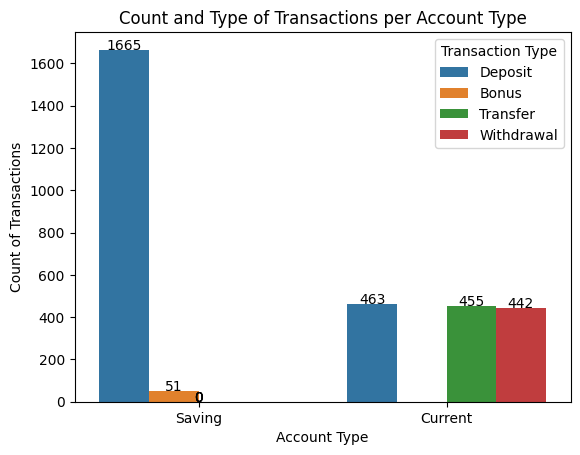

In [120]:
# Bar chart with number of transactions per account type (removing loan since there are no transactions)
ax = sns.countplot(
    data=(
        transactions_accounts[
            transactions_accounts['account_type'] != 'Loan'
        ]
    )
    , x='account_type', hue='transaction_type'
)

ax.legend(title='Transaction Type')

for p in ax.patches:
    height = p.get_height()
    ax.text(
        x=p.get_x() + p.get_width()/2,
        y=height + 0.5,
        s=int(height),
        ha='center'
    )

plt.xlabel('Account Type')
plt.ylabel('Count of Transactions')

plt.title('Count and Type of Transactions per Account Type')
plt.show()


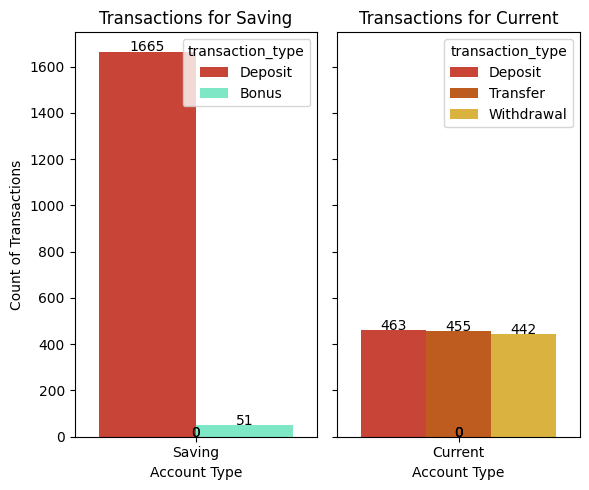

In [121]:
# Removing Loan account data since it doesn't have transactions
df = transactions_accounts[transactions_accounts['account_type'] != 'Loan']

# Displaying the data into 2 different subplots for better visability
fig, axes = plt.subplots(1, 2, figsize=(6, 5), sharey=True)

account_types = df['account_type'].unique()

palette_transaction_types = {
    'Deposit': '#E0301E',
    'Transfer': '#D85604',
    'Withdrawal': '#F3BE26',
    'Bonus': "#6BF9CC"
}

for ax, acct in zip(axes, account_types):
    subset = df[df['account_type'] == acct]
    sns.countplot(
        data=subset
        , x='account_type'
        , hue='transaction_type'
        , ax=ax
        , palette=palette_transaction_types
    )

    ax.set_title(f'Transactions for {acct}')
    ax.set_xlabel('Account Type')
    ax.set_ylabel('Count of Transactions')

    for p in ax.patches:
        height = p.get_height()
        ax.text(
            x=p.get_x() + p.get_width()/2,
            y=height + 0.5,
            s=int(height),
            ha='center'
        )

plt.tight_layout()
plt.show()


### 3.3. Overview of the costs and revenues per product in the last year (2023) together with product profitability
Consider the interest rates (loans and savings) and transaction fees (current account and savings) for the
calculation.

For the costs in this scenario, I will consider the interest we are paying to the customers for their savings accounts and the 500 CZK bonuses given on January 1st.
- Cost = (APR * average annual balance on savings accounts) + bonus on savings accounts

Whilst for the revenue I will consider the different fees on the transactions and the income for the loan accounts interests
- Revenue = sum fees + (APR * average annual balance on loan accounts)

Accordingly, the profit per Account will be the revenue minus the cost. To better understand the revenue on product level, I will group the results by Product, normalizing by AccountID.

And finally as for the margin, I will calculate it by dividing the profit by the revenue.

PD: Loan accounts are in EUR, I we will convert their value to CZK for better consistency.

In [122]:
# We isolate loan accounts opened in before 2024, in another words, active during 2023.
# For currency conversion, we will consider 24.0168 czech crowns per euro as the average annual conversion rate.

loan_acc_2023 = (
    transactions_accounts[
        (transactions_accounts['account_type'] == 'Loan') & 
        (transactions_accounts['DateOpened'] < '2024-01-01') &
        (transactions_accounts['balance_flat'] != 0)
    ]
).copy()

loan_acc_2023['balance_flat'] = loan_acc_2023['balance_flat'] * czech_crowns_per_euro_2023
loan_acc_2023['Currency'] = loan_acc_2023['Currency'].replace({'EUR': 'CZK'})

display(loan_acc_2023.head())


,TransactionID,AccountID,Amount,Date,transaction_type,Fee,BranchID,account_type,Balance,DateOpened,APR,CustomerID,Currency,balance_flat
59,<NA>,30,NaN,NaT,NaN,NaN,50,Loan,1.08815e+006 EUR,2023-07-15,0.07000,820,CZK,26133880.92000
205,<NA>,90,NaN,NaT,NaN,NaN,20,Loan,107067 EUR,2018-08-25,0.08000,90,CZK,2571406.72560
258,<NA>,120,NaN,NaT,NaN,NaN,50,Loan,331321 EUR,2008-11-26,0.11000,550,CZK,7957270.19280
259,<NA>,130,NaN,NaT,NaN,NaN,50,Loan,1.16114e+006 EUR,2009-01-11,0.10000,890,CZK,27886867.15200
260,<NA>,140,NaN,NaT,NaN,NaN,80,Loan,891186 EUR,2020-01-14,0.08000,860,CZK,21403435.92480


In [123]:
# Now I will isolate the transactions for the year 2023

transactions_2023 = (
    transactions_accounts[
        (transactions_accounts['Date'] >= '2023-01-01') &
        (transactions_accounts['Date'] < '2024-01-01')
        ]
).copy()


In [124]:
# And finally I will concatenate both df. The reason I did it like this was for consistency in the analysis.
# When filtering the transactions dataframe with the date filter, it was removing loan accounts since they don't contain
# transactions. Additionaly, I'm able to perform better cleaning and preprocessing on the combined dataframe.
# Removing Balance and Currency columns. We have balance_flat and all in CZK, so they are pointless.

tx_2023 = (
    pd.concat(
        [transactions_2023, loan_acc_2023]
        , ignore_index=True
    )
    .drop(
        columns=['Balance', 'Currency']
    ) # --> Test
)

display(tx_2023)

,TransactionID,AccountID,Amount,Date,transaction_type,Fee,BranchID,account_type,DateOpened,APR,CustomerID,balance_flat
0,29810,10,1986.04000,2023-04-25 21:54:38,Deposit,50.00000,50,Saving,2023-05-21,0.05000,930,12981.20000
1,29950,10,10250.66000,2023-05-21 00:00:00,Deposit,50.00000,50,Saving,2023-05-21,0.05000,930,12981.20000
2,30220,10,2830.54000,2023-07-16 11:14:45,Deposit,50.00000,50,Saving,2023-05-21,0.05000,930,12981.20000
3,28920,20,500.00000,2023-01-01 00:00:00,Bonus,0.00000,80,Saving,2008-05-27,0.06000,650,3887550.00000
4,30370,40,927.62000,2023-08-18 13:57:22,Deposit,5.00000,70,Current,2011-09-20,0.00000,200,60897.00000
...,...,...,...,...,...,...,...,...,...,...,...,...
230,<NA>,1370,NaN,NaT,NaN,NaN,70,Loan,2018-09-28,0.12000,260,22642846.90560
231,<NA>,1380,NaN,NaT,NaN,NaN,30,Loan,2021-10-02,0.07000,610,18653128.05600
232,<NA>,1470,NaN,NaT,NaN,NaN,70,Loan,2014-06-02,0.07000,880,20930425.04880
233,<NA>,1490,NaN,NaT,NaN,NaN,20,Loan,2017-12-19,0.08000,480,10423411.28400


In [125]:
# Not sure if I need this:

avg_balance_2023 = (
    transactions_2023
    .groupby(
        [
            'AccountID', 'account_type'
        ]
        , as_index=False
    )
    .agg(
        avg_balance=('balance_flat', 'mean')
    )
    .groupby(
        'account_type'
        , as_index=False
    )
    .agg(
        avg_balance=('avg_balance', 'mean')
    )
)

display(
    avg_balance_2023
)

,account_type,avg_balance
0,Current,53722.43818
1,Saving,1914674.11273


In [126]:
# Not sure if I need this:

display(
    transactions_accounts
    .groupby(
        ['account_type', 'transaction_type']
        , as_index=False
    )
    .agg(
        fee_mean=('Fee', 'mean')
        , fee_median=('Fee', 'median')
        , fee_count=('Fee', 'count')
        , fee_max=('Fee', 'max')
        , fee_min=('Fee', 'min')
    )
)

,account_type,transaction_type,fee_mean,fee_median,fee_count,fee_max,fee_min
0,Current,Deposit,5.00000,5.00000,463,5.00000,5.00000
1,Current,Transfer,0.00000,0.00000,455,0.00000,0.00000
2,Current,Withdrawal,100.00000,100.00000,442,100.00000,100.00000
3,Saving,Bonus,0.00000,0.00000,51,0.00000,0.00000
4,Saving,Deposit,50.00000,50.00000,1665,50.00000,50.00000


In [127]:
# Calculating total fees

total_fees = (
    tx_2023
    .groupby(
        'account_type'
        , as_index=False
    )
    .agg(
        fee_sum=('Fee', 'sum')
    )
)

total_fees['transaction_type'] = 'Fees'

display(
    total_fees
)

,account_type,fee_sum,transaction_type
0,Current,2185.00000,Fees
1,Loan,0.00000,Fees
2,Saving,3900.00000,Fees


In [128]:
total_bonus = (
    tx_2023[tx_2023['transaction_type'] == 'Bonus']
    .groupby(
        ['account_type', 'transaction_type']
        , as_index=False
    )
    .agg(
        bonus_sum=('Amount', 'sum')
    )
)

display(
    total_bonus
)


,account_type,transaction_type,bonus_sum
0,Saving,Bonus,25500.00000


In [129]:
total_savings_interest = (
    tx_2023[tx_2023['account_type'] == 'Saving']
    .groupby(
        ['account_type', 'AccountID', 'APR']
        , as_index=False
    )
    .agg(
        avg_balance = ('balance_flat', 'mean')
    )
)

total_savings_interest['savings_interest'] = total_savings_interest['APR'] * total_savings_interest['avg_balance']

total_savings_interest['transaction_type'] = 'Savings Interest'

total_savings_interest = (
    total_savings_interest
    .groupby(
        ['account_type', 'transaction_type']
        , as_index=False
    )
    .agg(
        savings_interest = ('savings_interest', 'sum')
    )
)

display(
    total_savings_interest
)

,account_type,transaction_type,savings_interest
0,Saving,Savings Interest,4806879.15000


Note: For the purpose of this study, I will not consider as negative (-) the inicial ammount provided for the loans. I will only consider the returns of loans interests as a positive income from this financial product. A different perspective could consider the initial deposit on a loan account as a negative cost, but in my case I won't follow this line.

In [130]:
total_loan_interest = (
    tx_2023[tx_2023['account_type'] == 'Loan']
    .groupby(
        ['account_type', 'AccountID', 'APR']
        , as_index=False
    )
    .agg(
        avg_balance = ('balance_flat', 'mean')
    )
)

total_loan_interest['loan_interest'] = total_loan_interest['APR'] * total_loan_interest['avg_balance']

total_loan_interest['transaction_type'] = 'Loan Interest'

total_loan_interest = (
    total_loan_interest
    .groupby(
        ['account_type', 'transaction_type']
        , as_index=False
    )
    .agg(
        loan_interest = ('loan_interest', 'sum')
    )
)

display(
    total_loan_interest
)


,account_type,transaction_type,loan_interest
0,Loan,Loan Interest,71801318.88518


In [133]:
display(total_loan_interest)
display(total_fees)
display(total_bonus)
display(total_savings_interest)

,account_type,transaction_type,loan_interest
0,Loan,Loan Interest,71801318.88518


,account_type,fee_sum,transaction_type
0,Current,2185.00000,Fees
1,Loan,0.00000,Fees
2,Saving,3900.00000,Fees


,account_type,transaction_type,bonus_sum
0,Saving,Bonus,25500.00000


,account_type,transaction_type,savings_interest
0,Saving,Savings Interest,4806879.15000


In [134]:
combined_summary = (
    pd.concat(
        [total_loan_interest, total_fees, total_bonus, total_savings_interest]
    )
    .fillna(0)
    .reset_index(drop=True)
)

display(combined_summary)

,account_type,transaction_type,loan_interest,fee_sum,bonus_sum,savings_interest
0,Loan,Loan Interest,71801318.88518,0.00000,0.00000,0.00000
1,Current,Fees,0.00000,2185.00000,0.00000,0.00000
2,Loan,Fees,0.00000,0.00000,0.00000,0.00000
3,Saving,Fees,0.00000,3900.00000,0.00000,0.00000
4,Saving,Bonus,0.00000,0.00000,25500.00000,0.00000
5,Saving,Savings Interest,0.00000,0.00000,0.00000,4806879.15000


In [135]:
combined_summary['revenue'] = combined_summary['loan_interest'] + combined_summary['fee_sum']
combined_summary['cost'] = combined_summary['bonus_sum'] + combined_summary['savings_interest']
combined_summary['profit'] = combined_summary['revenue'] - combined_summary['cost']

combined_summary['total_profitability'] = combined_summary.groupby('account_type')['profit'].transform('sum')

combined_summary

,account_type,transaction_type,loan_interest,fee_sum,bonus_sum,savings_interest,revenue,cost,profit,total_profitability
0,Loan,Loan Interest,71801318.88518,0.00000,0.00000,0.00000,71801318.88518,0.00000,71801318.88518,71801318.88518
1,Current,Fees,0.00000,2185.00000,0.00000,0.00000,2185.00000,0.00000,2185.00000,2185.00000
2,Loan,Fees,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,71801318.88518
3,Saving,Fees,0.00000,3900.00000,0.00000,0.00000,3900.00000,0.00000,3900.00000,-4828479.15000
4,Saving,Bonus,0.00000,0.00000,25500.00000,0.00000,0.00000,25500.00000,-25500.00000,-4828479.15000
5,Saving,Savings Interest,0.00000,0.00000,0.00000,4806879.15000,0.00000,4806879.15000,-4806879.15000,-4828479.15000


In [139]:
summary_by_product = (
    combined_summary
    .groupby('account_type', as_index=False)
    .agg(
        total_revenue=('revenue', 'sum'),
        total_cost=('cost', 'sum'),
        total_profit=('profit', 'sum')
    )
)

display(summary_by_product)


,account_type,total_revenue,total_cost,total_profit
0,Current,2185.00000,0.00000,2185.00000
1,Loan,71801318.88518,0.00000,71801318.88518
2,Saving,3900.00000,4832379.15000,-4828479.15000


Finally, for the product profitability, I will calculate it as:
- profitability = total_profit / (total_revenue + total_cost)

In [140]:
summary_by_product['profitability'] = summary_by_product['total_profit'] / summary_by_product['total_revenue']
summary_by_product['profitability'] = (
    summary_by_product['profitability']
    .replace(
        [float('inf'), -float('inf')]
        , 0
    )
)

display(summary_by_product)

,account_type,total_revenue,total_cost,total_profit,profitability
0,Current,2185.00000,0.00000,2185.00000,1.00000
1,Loan,71801318.88518,0.00000,71801318.88518,1.00000
2,Saving,3900.00000,4832379.15000,-4828479.15000,-1238.07158


/var/folders/6k/zfk3kxb1447czyrbwnhwzgsw0000gn/T/ipykernel_5501/77532739.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




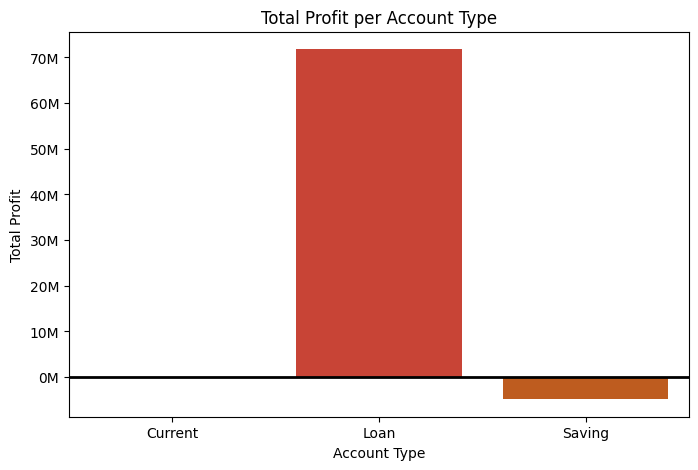

In [154]:
# I will plot the results in a bar chart and using Flash Cards (similar to PowerBI)

plt.figure(figsize=(8, 5))

sns.barplot(
    data=summary_by_product
    , x='account_type'
    , y='total_profit'
    , palette=palette_account_types
)

plt.title('Total Profit per Account Type')
plt.xlabel('Account Type')
plt.ylabel('Total Profit')

formatter = mtick.FuncFormatter(lambda x, _: f'{x/1_000_000:,.0f}M')
plt.gca().yaxis.set_major_formatter(formatter)

plt.axhline(0, color='black', linewidth=2)

plt.show()


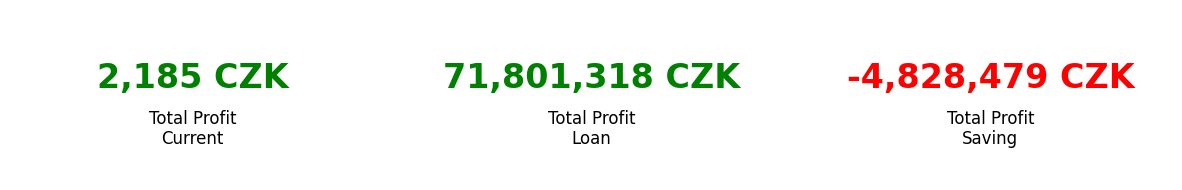

In [ ]:
accounts = summary_by_product['account_type']
profits = summary_by_product['total_profit']

num_accounts = len(accounts)
fig, axes = plt.subplots(1, num_accounts, figsize=(4*num_accounts, 2))

if num_accounts == 1:
    axes = [axes]

for ax, acct, val in zip(axes, accounts, profits):
    ax.axis('off')
    
    color = 'green' if val >= 0 else 'red'
    
    display_val = f'{int(val):,} CZK'
    
    ax.text(0.5, 0.6, display_val, fontsize=24, fontweight='bold', ha='center', va='center', color=color)
    ax.text(0.5, 0.3, f'Total Profit\n{acct}', fontsize=12, ha='center', va='center')
    ax.set_facecolor('#f0f0f0')

plt.tight_layout()
plt.show()


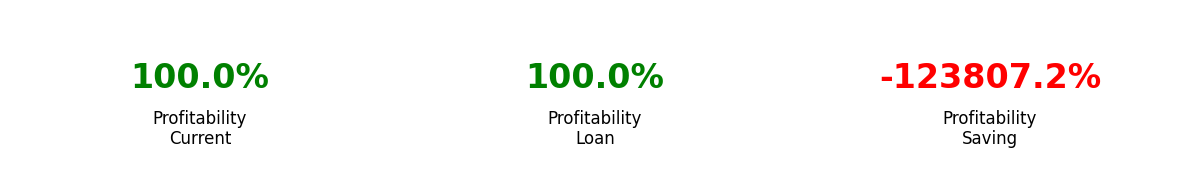

In [ ]:
accounts = summary_by_product['account_type']
profitability = summary_by_product['profitability']

num_accounts = len(accounts)
fig, axes = plt.subplots(1, num_accounts, figsize=(4*num_accounts, 2))

if num_accounts == 1:
    axes = [axes]

for ax, acct, val in zip(axes, accounts, profitability):
    ax.axis('off')
    
    color = 'green' if val >= 0 else 'red'
    
    display_val = f'{val*100:.1f}%'  # 1.0 -> 100%
    
    ax.text(0.5, 0.6, display_val, fontsize=24, fontweight='bold', ha='center', va='center', color=color)
    ax.text(0.5, 0.3, f'Profitability\n{acct}', fontsize=12, ha='center', va='center')
    ax.set_facecolor('#f0f0f0')

plt.tight_layout()
plt.show()
